<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning
In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU?
!nvidia-smi

Thu Jul 29 16:52:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We have done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-29 16:53:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-29 16:53:04 (71.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py` so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-07-29 16:53:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   150MB/s    in 1.1s    

2021-07-29 16:53:42 (150 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and sub-directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
print("Training data:")
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode='categorical')
print("Testing data:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Training data:
Found 750 files belonging to 10 classes.
Testing data:
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[8.89285736e+01 1.01928574e+02 1.35928574e+02]
   [9.06173477e+01 1.03617348e+02 1.37617355e+02]
   [9.18571472e+01 1.04214287e+02 1.38428574e+02]
   ...
   [5.10000000e+01 4.90000000e+01 7.02142639e+01]
   [5.05714149e+01 4.85714149e+01 6.95714188e+01]
   [4.96428566e+01 4.76428566e+01 6.86428604e+01]]

  [[9.10000000e+01 1.04000000e+02 1.38000000e+02]
   [9.10663300e+01 1.04066330e+02 1.38066330e+02]
   [9.05561218e+01 1.02913261e+02 1.37127548e+02]
   ...
   [5.19285736e+01 4.99285736e+01 7.11428375e+01]
   [5.20000000e+01 5.00000000e+01 7.10000000e+01]
   [5.20000000e+01 5.00000000e+01 7.10000000e+01]]

  [[9.34285736e+01 1.05785713e+02 1.41000000e+02]
   [9.24846954e+01 1.04841835e+02 1.40056122e+02]
   [9.50459213e+01 1.05045921e+02 1.41045914e+02]
   ...
   [5.25254936e+01 5.11683502e+01 7.21683273e+01]
   [5.14999847e+01 5.01428452e+01 7.09285583e+01]
   [5.02907906e+01 4.89336472e+01 6.97193604e+01]]

  ...

  [[1.74637955e+02 1.92785873e+02 2.17984863e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

Link: https://www/tensorflow.org/guide/keras/functional

<img src = "C:/Users/Hp/Desktop/Python/Udemy/TensorFlow/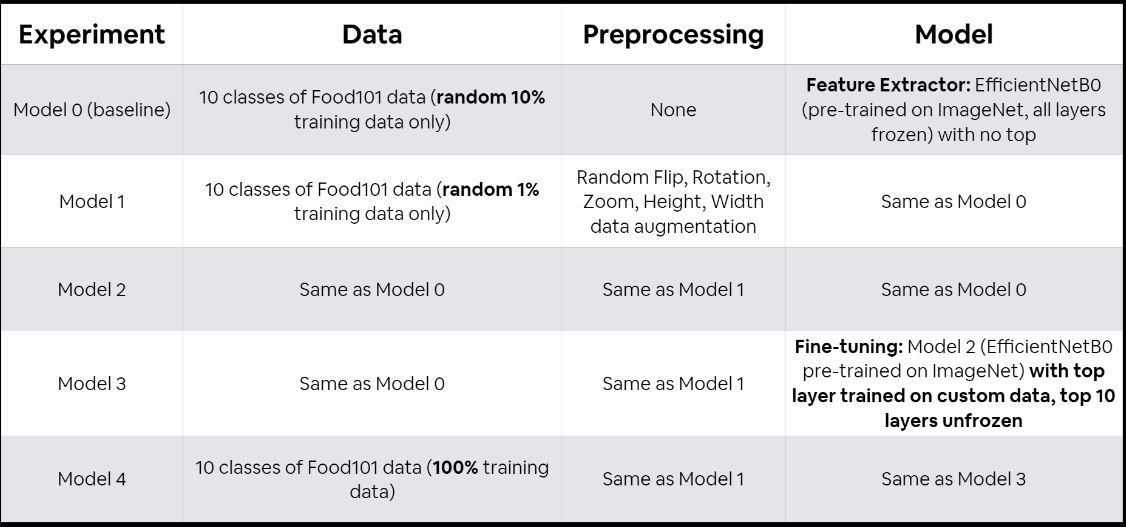Experiments.png"

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficentNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs and the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 10. Fit the model and save its history
history_0_10_percent_data = model_0.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)),
                                        callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                                               experiment_name="Model_0_10_percent_data")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: TensorBoard/Model_0_10_percent_data/20210729-165713
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 43s 327ms/step - loss: 1.9074 - accuracy: 0.4040 - val_loss: 1.3596 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 5s 208ms/step - loss: 1.1471 - accuracy: 0.7573 - val_loss: 0.9387 - val_accuracy: 0.7730
Epoch 3/5
24/24 [==============================] - 5s 199ms/step - loss: 0.8404 - accuracy: 0.8000 - val_loss: 0.7706 - val_accuracy: 0.8043
Epoch 4/5
24/24 [==============================] - 5s 205ms/step - loss: 0.6826 - accuracy: 0.8440 - val_loss: 0.7012 - val_accuracy: 0.8076
Epoch 5/5
24/24 [==============================] - 5s 205ms/step - loss: 0.5915 - accuracy: 0.8653 - val_loss: 0.6418 - val_accuracy: 0.8141


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 10s 123ms/step - loss: 0.6103 - accuracy: 0.8348


[0.610261857509613, 0.8348000049591064]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [14]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


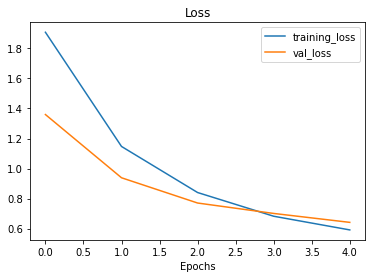

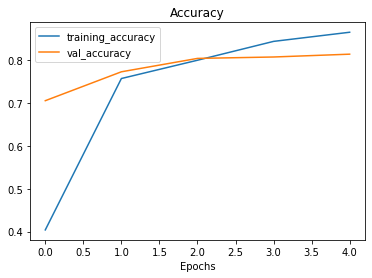

In [16]:
# Check out our model's training curves
plot_loss_curves(history_0_10_percent_data)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

**Conversion from 4D tensor to 2D tensor.**

In [17]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(shape=input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor : {global_average_pooled_tensor.shape}" )

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor : (1, 3)


In [18]:
# Let's replicate the Global Average Pooled 2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practise:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`...and see what happens.

**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then used to extract patterns out of for our own specific problem.

In [19]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f" Global Max Pooled 2D tensor:\n {global_max_pooled_tensor}")


 Global Max Pooled 2D tensor:
 [[0.9058464 1.1603122 1.6994323]]


In [20]:
tf.reduce_max(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...
How about we set up a bunch of experiments to find out:
0. `model_0`: use feature extraction transfer learning with 10% of the training data with no data augmentation (baseline_model)
1. `model_1`: use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3`: use fine tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: use fine tuning transfer learning on 100% of the training data with data augmentation

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency accross evaluation metrics.


### Getting and preprocessing data for model_1

In [21]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2021-07-29 17:04:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   191MB/s    in 0.7s    

2021-07-29 17:04:05 (191 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [23]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [24]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32

print("Training data")
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode="categorical")
print("Testing data")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode='categorical')

Training data
Found 70 files belonging to 10 classes.
Testing data
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
  # tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 byt EfficientNet(s) have built-in rescale
],name="data_augmentation_layer")

### Visualizing our data augmentation layer (and see what happens to our data)

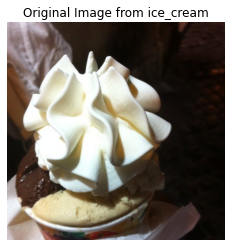

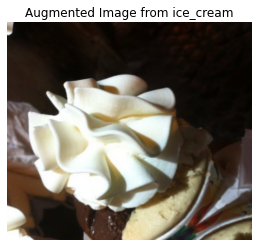

In [32]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(os.listdir(train_dir_1_percent))
target_dir = train_dir_1_percent + "/" + target_class
random_img = random.choice(os.listdir(target_dir))
img_path = target_dir + "/" + random_img

# Read and plot in the random image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis(False)
plt.title(f"Original Image from {target_class}");

# Now plot our augmented image
aug_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(aug_img)/255.)
plt.title(f"Augmented Image from {target_class}")
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [33]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape = input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer (already modified)
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Combine the model
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
history_1_1_percent_data = model_1.fit(train_data_1_percent,
                                       epochs=5,
                                       steps_per_epoch=len(train_data_1_percent),
                                       validation_data=test_data,
                                       validation_steps=int(0.25* len(test_data)),
                                       callbacks = create_tensorboard_callback(dir_name="TensorBoard",
                                                                               experiment_name="Model_1_1_percent_data"))

Saving TensorBoard log files to: TensorBoard/Model_1_1_percent_data/20210729-171125
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 11s 3s/step - loss: 2.3911 - accuracy: 0.0857 - val_loss: 2.2881 - val_accuracy: 0.1069
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1343 - accuracy: 0.2571 - val_loss: 2.1797 - val_accuracy: 0.1941
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9806 - accuracy: 0.3286 - val_loss: 2.0920 - val_accuracy: 0.2484
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.8120 - accuracy: 0.4857 - val_loss: 1.9910 - val_accuracy: 0.3306
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6194 - accuracy: 0.6429 - val_loss: 1.9010 - val_accuracy: 0.3734


In [34]:
# Check out model summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [35]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [36]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [37]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 9s 108ms/step - loss: 1.8982 - accuracy: 0.3876


[1.8982203006744385, 0.38760000467300415]

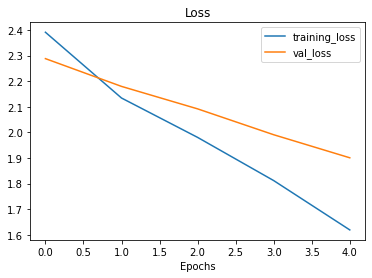

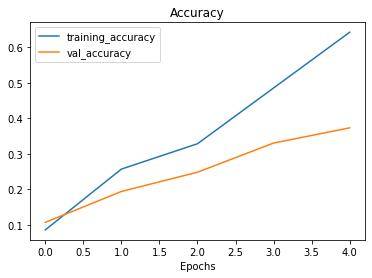

In [38]:
# How do the model with 1% of the data with data augmentation loss curves look?
plot_loss_curves(history_1_1_percent_data)

## Model 2: Feature Extraction transfer learning model with 10% of data and data augmentation

The training data here "train_data_10_percent" is already passed with loaders through tf.keras.preprocessing.image_dataset_from_directory and turns into batches of size 32. 

In [39]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [40]:
# Making the directory
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"
train_dir,test_dir

('10_food_classes_10_percent/train', '10_food_classes_10_percent/test')

In [41]:
# Setup data loaders for 10_percent test data
test_data= tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 2500 files belonging to 10 classes.


In [42]:
# Creating data augmentation layer for 10_percent_data
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
],name = 'data_augmentation_layer')

In [43]:
## Model Creation

# Setup base_model, freeze the model, and setup the input_shape
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Set up input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation layer
x = data_augmentation(inputs) # inputs gets passed into data_augmentation layer

# Setup base_model
x = base_model(x, training=False)

# Pooling Layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Output Dense layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Combining the model
model_2 = tf.keras.Model(inputs, outputs)

# Compiling the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
history_2_10_percent_data = model_2.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = int(0.25*len(test_data)),
                                        callbacks = create_tensorboard_callback(dir_name="TensorBoard",
                                                                                experiment_name="Model_2_10_percent_data"))

Saving TensorBoard log files to: TensorBoard/Model_2_10_percent_data/20210729-171818
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 581ms/step - loss: 2.0144 - accuracy: 0.3267 - val_loss: 1.4824 - val_accuracy: 0.6414
Epoch 2/5
24/24 [==============================] - 13s 532ms/step - loss: 1.3713 - accuracy: 0.6347 - val_loss: 1.0635 - val_accuracy: 0.7352
Epoch 3/5
24/24 [==============================] - 11s 437ms/step - loss: 1.0694 - accuracy: 0.7347 - val_loss: 0.8633 - val_accuracy: 0.7763
Epoch 4/5
24/24 [==============================] - 10s 386ms/step - loss: 0.9268 - accuracy: 0.7667 - val_loss: 0.7731 - val_accuracy: 0.7944
Epoch 5/5
24/24 [==============================] - 12s 442ms/step - loss: 0.8073 - accuracy: 0.7773 - val_loss: 0.7078 - val_accuracy: 0.8010


In [44]:
# Check the model summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


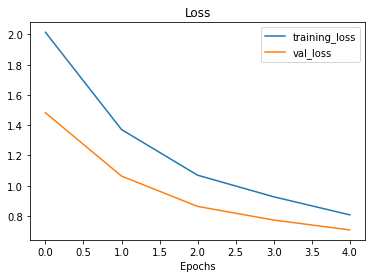

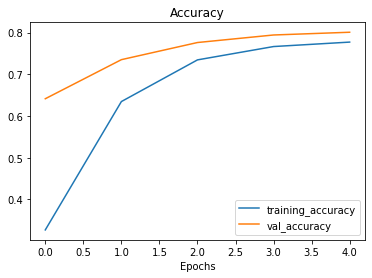

In [45]:
# Check the loss curves
plot_loss_curves(history_2_10_percent_data)

### Creating a ModelCheckPoint callback

Callbacks are a tool which can `add helpful functionality` to your models during training, evaluation or inference

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [46]:
# Set checkpoint path
checkpoint_path = "10_percent_data_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)
# Fitting the model_2
history_2_10_percent_data_mcpcb = model_2.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=int(0.25*len(test_data)),
                                              callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - 12s 463ms/step - loss: 0.7384 - accuracy: 0.7947 - val_loss: 0.6530 - val_accuracy: 0.8092

Epoch 00001: saving model to 10_percent_data_model_checkpoint_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 12s 486ms/step - loss: 0.6603 - accuracy: 0.8293 - val_loss: 0.6331 - val_accuracy: 0.8125

Epoch 00002: saving model to 10_percent_data_model_checkpoint_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 12s 496ms/step - loss: 0.6136 - accuracy: 0.8373 - val_loss: 0.6016 - val_accuracy: 0.8224

Epoch 00003: saving model to 10_percent_data_model_checkpoint_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 9s 339ms/step - loss: 0.5928 - accuracy: 0.8480 - val_loss: 0.6082 - val_accuracy: 0.8141

Epoch 00004: saving model to 10_percent_data_model_checkpoint_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 9s 344ms/step - loss: 0.5502 - acc

In [47]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 10s 110ms/step - loss: 0.6103 - accuracy: 0.8348


[0.610261857509613, 0.8348000049591064]

In [48]:
# Check model_2 results on all data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 108ms/step - loss: 0.5634 - accuracy: 0.8324


[0.5633527636528015, 0.8324000239372253]

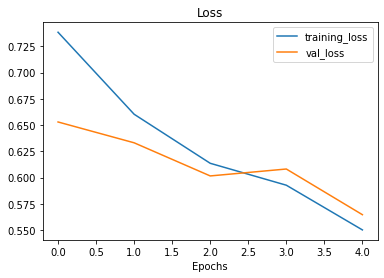

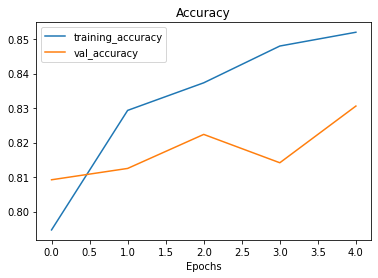

In [49]:
plot_loss_curves(history_2_10_percent_data_mcpcb)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [50]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [52]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 15s 174ms/step - loss: 0.5634 - accuracy: 0.8324


In [53]:
# If the results from our previously evaluated model_2 matched the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [54]:
results_10_percent_data_aug

[0.5633527636528015, 0.8324000239372253]

In [55]:
loaded_weights_model_results

[0.5633528232574463, 0.8324000239372253]

In [56]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(results_10_percent_data_aug, loaded_weights_model_results)

array([ True,  True])

In [57]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine tuning an existing model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [58]:
# Layers in loaded model
model_2.layers

In [59]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f01b62eec10> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f01b2126790> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f01b3180890> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f029602aad0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f01b314a510> True


In [60]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [61]:
# How many trainable variables are in our base_model?
print(len(model_2.layers[2].trainable_variables))

0


In [62]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base model.trainable = True
base_model.trainable = True

# Freeze all layers expect for last 10
for layer in model_2.layers[2].layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tuning you typically want to lower the learning rate by 10x.
    metrics=["accuracy"]
)

**Note:** When using fine tuning it's best practise to lower your learning rate by some amount. How much? This is a hyper-parameter you can tune. But a good rule of thumb is atleast 10x (though different sources will claim other values). 

A good resource for information on this is the ULMFit Paper: https://arxiv.org/abs/1801.06146

In [64]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [66]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(base_model.trainable_variables))
print(len(model_2.layers[2].trainable_variables))
print(len(model_2.trainable_variables))

10
10
12


In [67]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f01b62eec10> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f01b2126790> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f01b3180890> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f029602aad0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f01b314a510> True


In [68]:
# Refit the model (same as model_2 except with more trainable layers)
history_10_percent_data_aug_fine_tune = model_2.fit(train_data_10_percent,
                                                    epochs = 10,
                                                    steps_per_epoch=len(train_data_10_percent),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.25*len(test_data)),
                                                    initial_epoch = history_2_10_percent_data_mcpcb.epoch[-1], # start training from previous last epoch
                                                    callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                                                           experiment_name="Model_3_10_percent_data_aug_fine_tune")])

Saving TensorBoard log files to: TensorBoard/Model_3_10_percent_data_aug_fine_tune/20210729-173922
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 546ms/step - loss: 0.4932 - accuracy: 0.8587 - val_loss: 0.5189 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 9s 358ms/step - loss: 0.4087 - accuracy: 0.8733 - val_loss: 0.5066 - val_accuracy: 0.8224
Epoch 7/10
24/24 [==============================] - 8s 337ms/step - loss: 0.3709 - accuracy: 0.8960 - val_loss: 0.4759 - val_accuracy: 0.8405
Epoch 8/10
24/24 [==============================] - 9s 361ms/step - loss: 0.3137 - accuracy: 0.9173 - val_loss: 0.5235 - val_accuracy: 0.8306
Epoch 9/10
24/24 [==============================] - 8s 314ms/step - loss: 0.2788 - accuracy: 0.9227 - val_loss: 0.5077 - val_accuracy: 0.8339
Epoch 10/10
24/24 [==============================] - 9s 375ms/step - loss: 0.2377 - accuracy: 0.9413 - val_loss: 0.5130 - val_accuracy: 0.8306


In [69]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.4783 - accuracy: 0.8404


In [70]:
results_10_percent_data_aug

[0.5633527636528015, 0.8324000239372253]

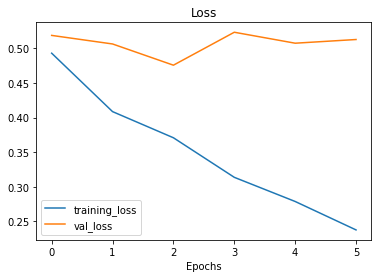

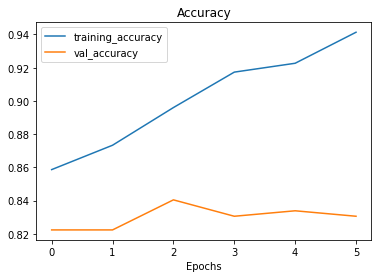

In [71]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_10_percent_data_aug_fine_tune)


# Epochs :
# 0 -> 5 (initial_epoch)
# 1 -> 6
# 2 -> 7
# 3 -> 8
# 4 -> 9
# 5 -> 10


The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [72]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]
  
  # Make plots
  plt.figure(figsize=(10,7))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper left")
  plt.title("Training and validation Accuracy")

  # Plot loss
  plt.figure(figsize=(10,7))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation Loss")

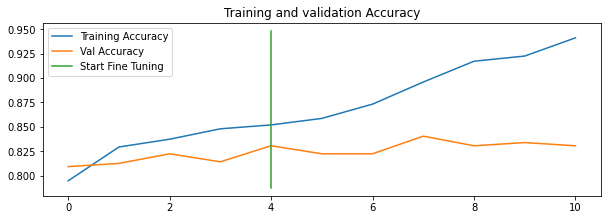

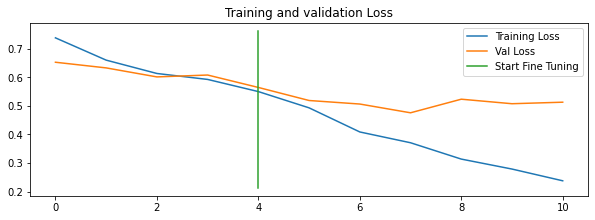

In [73]:
compare_histories(history_2_10_percent_data_mcpcb, history_10_percent_data_aug_fine_tune)

## Model 4: Fine tuning an existing model on all of the data

In [74]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the data
unzip_data("10_food_classes_all_data.zip")

--2021-07-29 17:51:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   161MB/s    in 3.1s    

2021-07-29 17:51:40 (161 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [75]:
# Getting the number of images in directories
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [76]:
# Set up directories
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [78]:
# Setup data loaders and turns into batches
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

print("Training_data")
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                 image_size = IMG_SHAPE,
                                                                 label_mode = "categorical",
                                                                 batch_size = BATCH_SIZE)
print("Testing data")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SHAPE,
                                                                batch_size = BATCH_SIZE)

Training_data
Found 7500 files belonging to 10 classes.
Testing data
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previosu experiments (all experiments have used the same test dataset).

Let's verify this...

In [79]:
# Evaluate model_2 (this is the fine-tuned on 10 percent of the data version)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 143ms/step - loss: 0.4783 - accuracy: 0.8404


[0.47829556465148926, 0.840399980545044]

In [80]:
results_fine_tuned_10_percent

[0.47829559445381165, 0.840399980545044]

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature_extraction weights.

Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was tuned from.

In [81]:
# Revert back to feature extraction version
model_2.load_weights(checkpoint_path)

In [82]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 13s 156ms/step - loss: 0.5634 - accuracy: 0.8324


[0.5633525848388672, 0.8324000239372253]

In [83]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug == model_2.evaluate(test_data)

79/79 [==============================] - 13s 152ms/step - loss: 0.5634 - accuracy: 0.8324


True

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reload the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [85]:
# Check which layers are tunable in the whole model
for i, layer in enumerate(model_2.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [86]:
# Let's drill into our base_model (EfficientNetB0) and see what layers are trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [88]:
# Compile the model
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

In [93]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = 10

history_all_data_aug = model_2.fit(train_data,
                                   epochs = fine_tune_epochs,
                                   steps_per_epoch = len(train_data),
                                   validation_data = test_data,
                                   validation_steps = int(0.25 * len(test_data)),
                                   initial_epoch = history_2_10_percent_data_mcpcb.epoch[-1],
                                   callbacks = create_tensorboard_callback(dir_name = "TensorBoard",
                                                                           experiment_name = "Model_4_all_data_aug"))

Saving TensorBoard log files to: TensorBoard/Model_4_all_data_aug/20210729-194748


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
235/235 [==============================] - 67s 249ms/step - loss: 0.6868 - accuracy: 0.7771 - val_loss: 0.3954 - val_accuracy: 0.8520
Epoch 6/10
235/235 [==============================] - 68s 287ms/step - loss: 0.5633 - accuracy: 0.8208 - val_loss: 0.3497 - val_accuracy: 0.8766
Epoch 7/10
235/235 [==============================] - 68s 286ms/step - loss: 0.5027 - accuracy: 0.8360 - val_loss: 0.3329 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 64s 270ms/step - loss: 0.4659 - accuracy: 0.8535 - val_loss: 0.3410 - val_accuracy: 0.8865
Epoch 9/10
235/235 [==============================] - 64s 269ms/step - loss: 0.4224 - accuracy: 0.8631 - val_loss: 0.3209 - val_accuracy: 0.9013
Epoch 10/10
235/235 [==============================] - 59s 249ms/step - loss: 0.3948 - accuracy: 0.8736 - val_loss: 0.2761 - val_accuracy: 0.9013


In [94]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 12s 144ms/step - loss: 0.2968 - accuracy: 0.9028


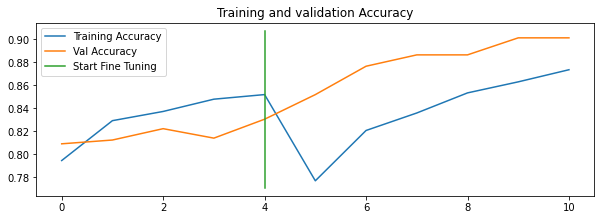

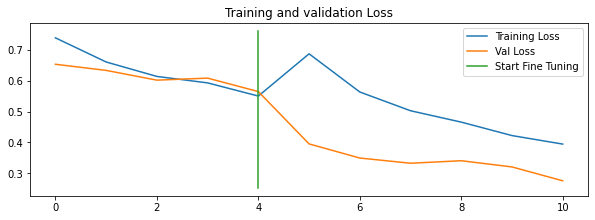

In [95]:
compare_histories(original_history=history_2_10_percent_data_mcpcb,
                  new_history = history_all_data_aug)

## Viewing our experiment data on TensorBoard

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (5 Models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./TensorBoard \
--name "Transfer Learning Experiments with 10 Food101 Classes" \
--description "A Series of different transfer learning experiments with varying amounts of data and fine-tuning." \
--one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/cONzu3FBTzWqwrNUr1ur9g/

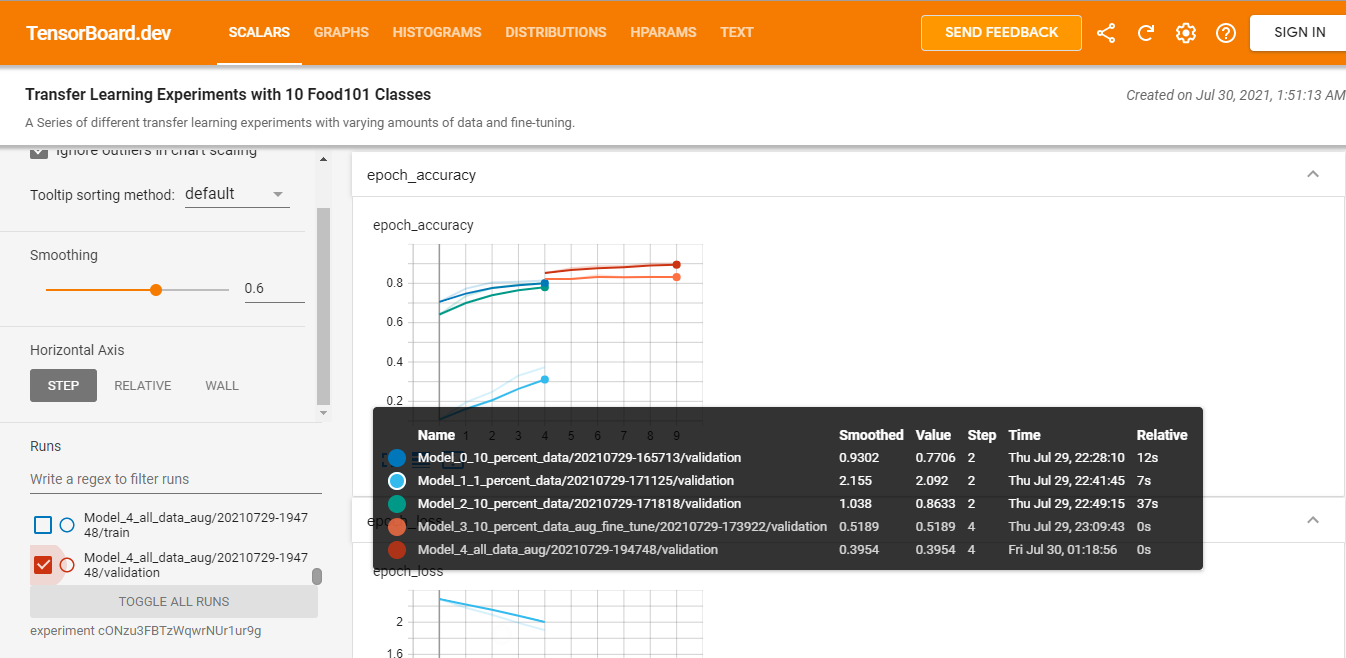

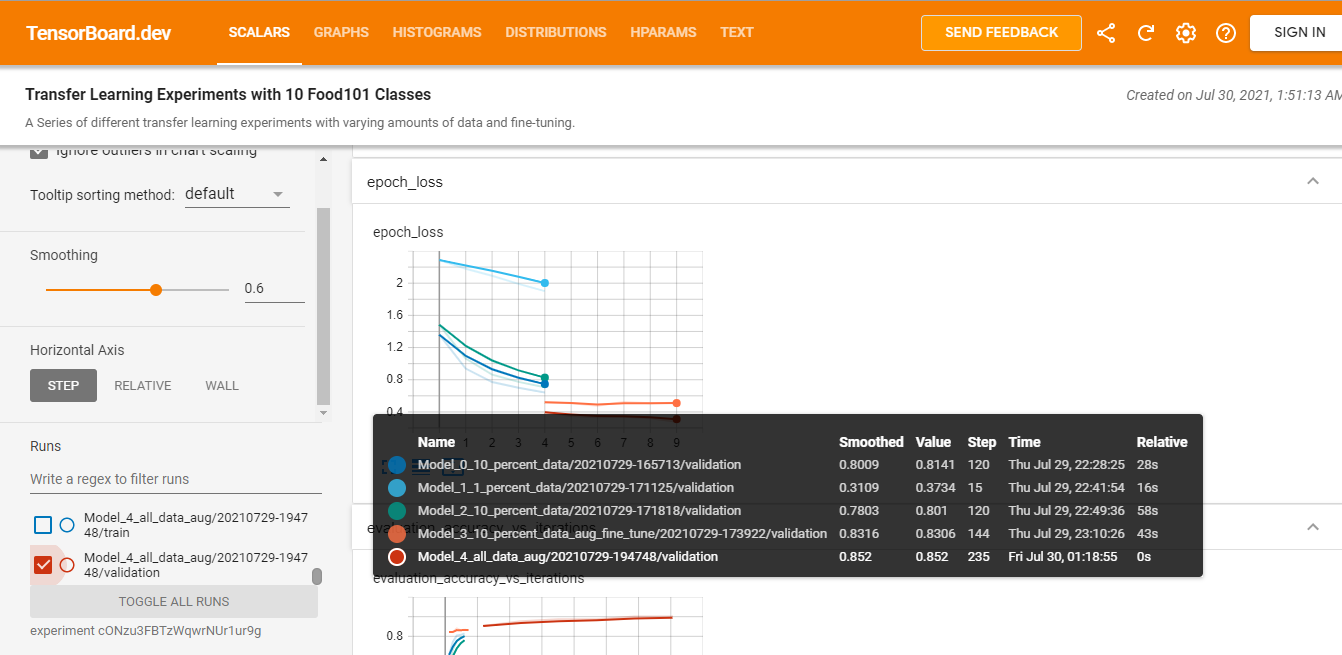

In [98]:
# View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

2021-07-29 20:39:11.425874: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/cONzu3FBTzWqwrNUr1ur9g/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A Series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   cONzu3FBTzWqwrNUr1ur9g
	Created              2021-07-29 20:21:12 (18 minutes ago)
	Updated              2021-07-29 20:21:20 (18 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4238297
https://tensorboard.dev/experiment/gqBgqdLbQlmuXiwyGRdkkA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Des

In [ ]:
# !tensorboard dev delete --experiment_id xxxxxxx